# LANL Earthquake Prediction

## Get Data:

To get the data, we only have to download it from the database and open it, altough there was to much data, thus, I splitted the data into 4196 csv files of 150000 rows each

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# define constants
DATA_DIR = "data/"
TRAIN_DIR = "data/train/"
MODELS_DIR = "models/"
TEST_DIR = os.path.join(DATA_DIR, "test/")


# load data into dataframe
train_files = os.listdir(TRAIN_DIR);
train_files.sort()
LANL_train_set = pd.read_csv(os.path.join(TRAIN_DIR, train_files[42]))
LANL_train_array = np.array(LANL_train_set['acoustic_data'])
LANL_train_labels = np.array(LANL_train_set['time_to_failure'])
LANL_mean = np.mean(LANL_train_array)
LANL_std  = np.std(LANL_train_array)
LANL_variance = np.var(LANL_train_array)

## Analize Data:

First of all, lets plot the head of the data into our notebook, tyo see an example of what we are working with

In [2]:
LANL_train_set.head()

,acoustic_data,time_to_failure
0,8,11.3737
1,8,11.3737
2,3,11.3737
3,3,11.3737
4,1,11.3737


Now, let's plot all the acoustic data to have a more visual representation of it. For this, I made a function that generates different plots we can use such as an histogram and a boxplot

In [3]:
def gen_plots(x):
    n_bins = 70
    rows = 3
    cols = 1
    plt.figure(1, figsize=(7, 15))
    # plot data
    plt.subplot(rows, cols, 1)
    plt.plot(x)
    
    # plot histogram
    hist = plt.subplot(rows, cols, 2)
    hist.set_title("Histogram")
    n, bins, patches = plt.hist(x, n_bins, facecolor='orange', alpha=0.5)
    
    # plot boxplot
    boxplot = plt.subplot(rows, cols, 3)
    plt.boxplot(x)
    boxplot.set_title("Boxplot")
    plt.show()


Next we generate the different plots, we can see form the histogram that the instance follows a normal distribution and the most of the values are positive, this may vary from instance to instace, altought all of them a similar distribition. 

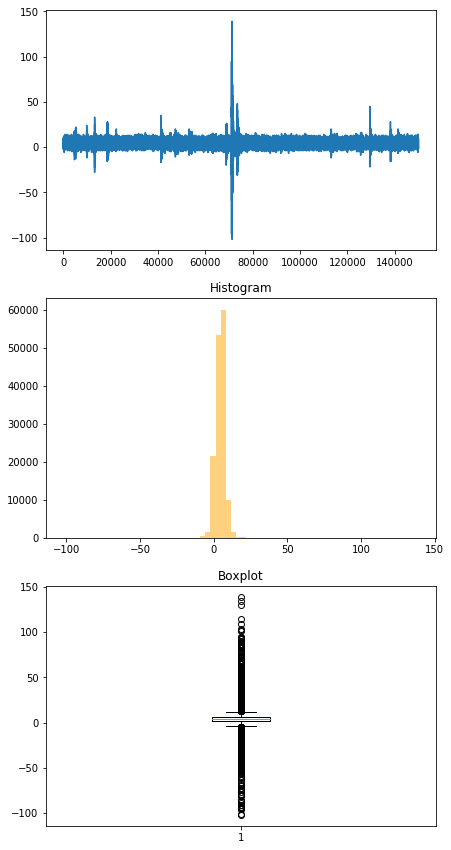

In [4]:
gen_plots(LANL_train_array)

The data we are using right represents only a single intance wich is a time segment with only one label. With this instance we might neeed to do some feature engeneering. Let's see some example of qualities we can get from the instance and its label. From this data, I concluded that we can use the mean of all the failure times from the instance as the single label for the instance.

In [5]:
print("Mean: ", LANL_mean)
print("Standard deviation: ", LANL_std)
print("Variance: ", LANL_variance)
print("Time to failure mean: ", np.mean(LANL_train_labels))
print("Max time to failure: ", np.max(LANL_train_labels))
print("Min time to failure: ", np.min(LANL_train_labels))

Mean:  4.3839733333333335
Standard deviation:  4.22277844702066
Variance:  17.83185781262222
Time to failure mean:  11.354673242272735
Max time to failure:  11.373699597
Min time to failure:  11.335396800000002


We can see we are starting to make new features for this instance, let's save it in a pandas dataframe 

In [6]:
features = np.array([LANL_mean, LANL_std, LANL_variance])
LANL_train = pd.DataFrame({'mean' : [features[0]], 'deviation' : [features[1]], 'variance' : features[2]})

In [7]:
LANL_train

,mean,deviation,variance
0,4.383973,4.222778,17.831858


Now we have a nice way to store all the features for each instance. But it seems a bit deorganized and once we start adding functions and features it will get more complicated; so let's make a simple pipeline to automatize all the process. For this I created a list of functions to make each feature and an estimator that applies each function to the instance. 

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, kurtosis

cv =  lambda x: np.std(x) / np.mean(x)


# feature functions
feature_names = ['mean', 'deviation', 'variance', 
                 'min', 'max', 'skewness',
                 'kurtosis', 'quantile_25', 'quantile_50',
                 'quantile_75', 'q95', 'q99', 'q05', 'q01', 'abs_q95', 
                 'abs_q99', 'abs_q05', 'abs_q01', 'coeficient__of_variation',
                 'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                 'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                 'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                 'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000']
for window in ['10', '100', '1000']:
    feature_names.append('ave_roll_std_' + window)
    feature_names.append('std_roll_std_' + window)
    feature_names.append('max_roll_std_' + window)
    feature_names.append('min_roll_std_' + window)
    feature_names.append('q01_roll_std_' + window)
    feature_names.append('q05_roll_std_' + window)
    feature_names.append('q95_roll_std_' + window)
    feature_names.append('q99_roll_std_' + window)
    feature_names.append('av_change_abs_roll_std_' + window)
    feature_names.append('abs_max_roll_std_' + window)
    feature_names.append('ave_roll_mean_' + window)
    feature_names.append('std_roll_mean_' + window)
    feature_names.append('max_roll_mean_' + window)
    feature_names.append('min_roll_mean_' + window)
    feature_names.append('q01_roll_mean_' + window)
    feature_names.append('q05_roll_mean_' + window)
    feature_names.append('q95_roll_mean_' + window)
    feature_names.append('q99_roll_mean_' + window)
    feature_names.append('av_change_abs_roll_mean_' + window)
    feature_names.append('abs_max_roll_mean_' + window)
    
feature_trans = {'mean' : np.mean, 'deviation' : np.std, 'variance' : np.var, 
                 'min' : np.min, 'max' : np.max, 'skewness' : skew,
                 'kurtosis' : kurtosis, 'quantile' : np.quantile, 'coeficient__of_variation' : cv}

class FeatureGenerator(BaseEstimator, TransformerMixin):
   
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for name in feature_trans:
            if name == 'quantile':
                features.append(feature_trans[name](X, .25))
                features.append(feature_trans[name](X, .50))
                features.append(feature_trans[name](X, .75))
                features.append(feature_trans[name](X, 0.95))
                features.append(feature_trans[name](X, 0.99))
                features.append(feature_trans[name](X, 0.05))
                features.append(feature_trans[name](X, 0.01))
                features.append(feature_trans[name](np.abs(X), 0.95))
                features.append(feature_trans[name](np.abs(X), 0.99))
                features.append(feature_trans[name](np.abs(X), 0.05))
                features.append(feature_trans[name](np.abs(X), 0.01))
            else:
                features.append(feature_trans[name](X))
        features.append(np.mean(X[:50000]))
        features.append(np.mean(X[50000:]))
        features.append(np.mean(X[:10000]))
        features.append(np.mean(X[10000:]))
        features.append(np.std(X[:50000]))
        features.append(np.std(X[50000:]))
        features.append(np.std(X[:10000]))
        features.append(np.std(X[10000:]))
        features.append(np.min(X[:50000]))
        features.append(np.min(X[50000:]))
        features.append(np.min(X[:10000]))
        features.append(np.min(X[10000:]))
        features.append(np.max(X[:50000]))
        features.append(np.max(X[50000:]))
        features.append(np.max(X[:10000]))
        features.append(np.max(X[10000:]))
        X = pd.Series(X)
        for windows in [10, 100, 1000]:
            x_roll_std = X.rolling(windows).std().dropna().values
            x_roll_mean = X.rolling(windows).mean().dropna().values
            features.append(x_roll_std.mean())
            features.append(x_roll_std.std())
            features.append(x_roll_std.max())
            features.append(x_roll_std.min())
            features.append(np.quantile(x_roll_std, 0.01))
            features.append(np.quantile(x_roll_std, 0.05))
            features.append(np.quantile(x_roll_std, 0.95))
            features.append(np.quantile(x_roll_std, 0.99))
            features.append(np.mean(np.diff(x_roll_std)))
            features.append(np.abs(x_roll_std).max())
            features.append(x_roll_mean.mean())
            features.append(x_roll_mean.std())
            features.append(x_roll_mean.max())
            features.append(x_roll_mean.min())
            features.append(np.quantile(x_roll_mean, 0.01))
            features.append(np.quantile(x_roll_mean, 0.05))
            features.append(np.quantile(x_roll_mean, 0.95))
            features.append(np.quantile(x_roll_mean, 0.99))
            features.append(np.mean(np.diff(x_roll_mean)))
            features.append(np.abs(x_roll_mean).max())
        return np.c_[features]

Now let's generate the features for all the instances in the dataset. The following function automates all the process from getting the data, appaying the function and finally normalazing it. 

In [9]:
from sklearn.preprocessing import StandardScaler

def GetTrainInstances(max_inst=-1, directory=TRAIN_DIR, normalize=True, log=False):
    LANL_X = []
    LANL_y = []
    i = 0

    gen = FeatureGenerator()
    scaler = StandardScaler()
    max_instances = max_inst
    print("Progress:")
    for file in train_files:
        if i == max_instances:
            break
        if i % 42 == 0:
            print(int(i / 42), end='.')
        tmp = pd.read_csv(os.path.join(directory, file))
        tmp_data = np.array(tmp['acoustic_data'])
        tmp_labels = np.array(tmp['time_to_failure'])
        if log:
            for element in tmp_data:
                if element < 0:
                    element = -np.log10(abs(element))
                elif element > 0:
                    element = np.log10(element)
        LANL_X.append(gen.fit_transform(tmp_data))
        # for all time instances we get the mean
        LANL_y.append(np.mean(tmp_labels)) 
        i += 1
    if normalize:
        LANL_X = scaler.fit_transform(np.array(LANL_X).reshape(max_instances, len(feature_names)))
    LANL_X = pd.DataFrame(np.array(LANL_X).reshape(max_instances, len(feature_names)), columns=feature_names)
    LANL_y = pd.DataFrame(np.array(LANL_y).reshape(max_instances, 1), columns=['time_to_failure'])
    LANL_X.to_csv(os.path.join(DATA_DIR, "train_data.csv"), sep=',', encoding='utf-8', index=False)
    LANL_y.to_csv(os.path.join(DATA_DIR, "train_labels.csv"), sep=',', encoding='utf-8', index=False)
    return LANL_X, LANL_y
            
    

In [220]:
LANL_X, LANL_y = GetTrainInstances(max_inst=-1, normalize=True, log=False)

Progress:
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

We could also load the dataset that has been generated. 

In [10]:
LANL_X = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
LANL_y = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

For now I only loaded 200 instances of the dataset because it is easier to work with. When we start training the model I will include all the dataset

In [11]:
LANL_X.head()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.080583,0.193218,-0.218194,-0.313703,-0.491310,1.594316,0.947037,0.288822,...,1.421036,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-0.004742
1,0.805716,0.004734,-0.064868,-0.018037,0.063936,0.553891,0.431696,-0.405852,0.947037,0.288822,...,0.802052,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,0.007341
2,1.511155,0.049252,-0.060230,0.163039,-0.086289,0.191534,-0.492831,-0.405852,0.947037,0.288822,...,1.508574,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.099556
3,1.494934,0.043950,-0.060796,-0.187796,0.122560,1.321245,0.683938,-0.405852,0.947037,0.288822,...,1.491578,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,0.068076
4,1.520242,0.088495,-0.055927,0.087590,-0.067969,-0.128324,-0.217434,-0.405852,0.947037,0.288822,...,1.525581,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,0.138032


Now let's try to find out more information about the dataset looking at the correlation of the features

In [12]:
LANL_X.corr()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
mean,1.000000,0.010820,0.010008,-0.006316,0.013494,-0.002517,-0.001545,0.511647,0.794163,0.522219,...,0.999988,0.014316,0.091174,0.100297,0.515521,0.916734,0.933774,0.597466,0.003627,0.091174
deviation,0.010820,1.000000,0.956127,-0.963867,0.964585,0.055543,0.333802,-0.382487,-0.006846,0.408645,...,0.011237,0.907130,0.949747,-0.954084,-0.758859,-0.268339,0.239889,0.720341,-0.083912,0.949747
variance,0.010008,0.956127,1.000000,-0.904037,0.895722,0.029222,0.183733,-0.286210,-0.000429,0.318630,...,0.010462,0.939392,0.951774,-0.955905,-0.794548,-0.277607,0.245352,0.740951,-0.090695,0.951774
min,-0.006316,-0.963867,-0.904037,1.000000,-0.958889,-0.006328,-0.463737,0.346719,0.009994,-0.371779,...,-0.006701,-0.873725,-0.933443,0.937743,0.724281,0.257732,-0.226616,-0.666382,0.078587,-0.933443
max,0.013494,0.964585,0.895722,-0.958889,1.000000,0.140661,0.463951,-0.337078,-0.003218,0.366588,...,0.013945,0.842807,0.904893,-0.910499,-0.705854,-0.239647,0.215590,0.665360,-0.089456,0.904893
skewness,-0.002517,0.055543,0.029222,-0.006328,0.140661,1.000000,0.144331,-0.021153,0.009313,0.009858,...,-0.002476,0.018926,0.030619,-0.035462,-0.020706,-0.011176,0.001959,0.027146,-0.015912,0.030619
kurtosis,-0.001545,0.333802,0.183733,-0.463737,0.463951,0.144331,1.000000,-0.125803,-0.015036,0.132285,...,-0.001515,0.172808,0.270811,-0.277989,-0.132016,-0.045031,0.034692,0.123722,-0.007556,0.270811
quantile_25,0.511647,-0.382487,-0.286210,0.346719,-0.337078,-0.021153,-0.125803,1.000000,0.435939,-0.082020,...,0.511587,-0.298628,-0.267281,0.360986,0.524919,0.583910,0.376721,0.054310,-0.001396,-0.267281
quantile_50,0.794163,-0.006846,-0.000429,0.009994,-0.003218,0.009313,-0.015036,0.435939,1.000000,0.409245,...,0.794129,0.007862,0.063367,0.088538,0.410808,0.727135,0.740455,0.467624,0.000019,0.063367
quantile_75,0.522219,0.408645,0.318630,-0.371779,0.366588,0.009858,0.132285,-0.082020,0.409245,1.000000,...,0.522259,0.332238,0.380289,-0.281267,-0.009354,0.356877,0.592698,0.573243,-0.010166,0.380289


With what we have now let's divide the data into training set and testing set

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(LANL_X), np.array(LANL_y), test_size=0.2, random_state=42)

In [14]:
y_train.shape

(3355, 1)

Before going any further I want to make a function that makes predictions and saves them for upload to kaggle

In [15]:
def MakeSubmission(model):
    col_names = ['seg_id', 'time_to_failure']
    sub  = pd.DataFrame(columns = col_names)
    gen = FeatureGenerator()
    scaler = StandardScaler()
    for i, file in enumerate(os.listdir(TEST_DIR)):
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        scaler.fit_transform(d)
        pred = model.predict(d.reshape(1, -1))
        print(pred)
        sub.loc[i] = [file[:-4], pred[0]]
        
    sub.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)
        

Wwe also need a method to validate how good our model is 

In [27]:
from sklearn.model_selection import cross_val_score

def display_scores(model, X, y):
    scores = cross_val_score(model, X, y.reshape(-1), 
                             scoring="neg_mean_absolute_error", cv=10)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Training

Now let's see how well a model performs. I uses a random forest because I like them and not for anything in particular, altough later we will need to test a lot of models and select a few promising

### Random Forest

In [268]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=1000, criterion="mae", 
                                    random_state=42, n_jobs=-1)

In [269]:
model_rfr.fit(X_train, y_train.reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Before going any further let's save our model

In [278]:
from sklearn.externals import joblib

joblib.dump(model_rfr, os.path.join(MODELS_DIR, "model_rfr.pkl"))

['models/model_rfr.pkl']

Instead of fitting and creating our model let's load it 

In [63]:
from sklearn.externals import joblib

model_rfr = joblib.load(os.path.join(MODELS_DIR, "model_rfr.pkl"))

Now that we have trained the random forest regressor, let's find out the feature importances. As we can see the deviation is the feature that has the most importance, altought it does not have to much importance only 20% 

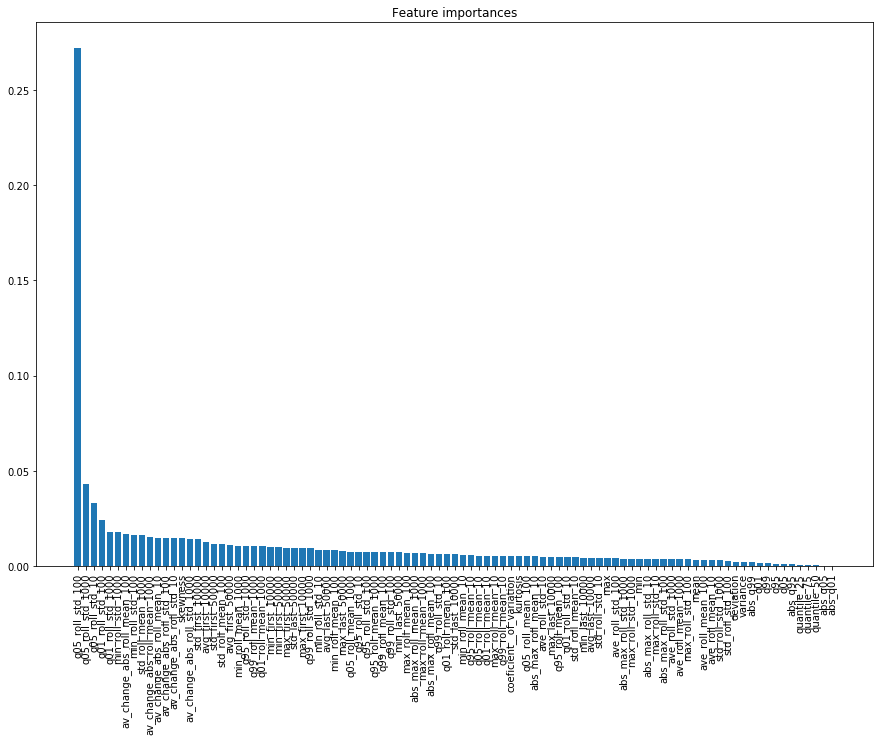

In [270]:
# calculate feature importances
importances = model_rfr.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# rearrange feature names so that they match the sorted feature importances
names = [feature_names[i] for i in indices]

# create plot
plt.figure(figsize=(15,10))
plt.title("Feature importances")

# add bars
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# show plot
plt.show()

In [275]:
model_rfr.predict(X_test)

array([ 8.76205882,  8.01433184,  8.52677866,  7.32340854,  9.20563484,
        5.61571036,  2.70297072,  9.66813927,  7.02056701,  5.7074825 ,
        2.56915353,  2.85830475,  9.2967535 ,  5.7932214 ,  2.27641387,
        9.48606584,  5.34726472,  8.42873903,  7.1105456 ,  2.72940293,
        4.46006348,  2.22209987,  9.56364931,  2.32201443,  7.78555086,
        3.40587997,  5.19613359,  3.16750066,  6.24946027,  6.96140252,
        2.34468897,  2.54947316,  7.62782178,  2.58617292,  3.16235032,
        2.73860422,  7.28332687,  2.08244671,  2.77469169,  6.20541866,
        2.41061851,  2.92460169,  8.03706256,  3.20640188,  7.48623814,
        2.7777598 ,  9.22014613,  2.93861777,  5.16946141,  3.94339915,
        8.89997207,  3.34987752,  7.37057283,  5.73548407,  3.9511795 ,
        8.48858092,  6.03953295,  0.9828591 ,  5.00180592,  8.8846839 ,
        8.81564637,  2.74874775,  3.16434784,  3.22233474,  8.12128966,
        9.02622229,  8.76772789,  3.06967677,  2.17795971,  2.96

Let's make a simple prediction of our selected testing test

In [276]:
display_scores(model_rfr, X_test, y_test.reshape(-1))

Scores: [-2.18777971 -2.53298343 -2.36751083 -2.48313203 -2.1634957  -1.87918274
 -1.80613349 -1.6543167  -2.54180752 -2.16399042]
Mean: -2.178033256479035
Standard deviation: 0.29828040147028057


In [301]:
MakeSubmission(model_rfr)

[4.01472092]
[3.93832938]
[4.02564697]
[4.00269274]
[3.9583305]
[3.9503046]
[3.99541803]
[4.0118805]
[4.00173033]
[3.94187724]
[3.94373801]
[3.94487052]
[4.00881822]
[3.99333351]
[3.94988711]
[3.96512926]
[4.00645276]
[4.02700777]
[3.95758862]
[4.02819849]
[4.03350011]
[3.93940189]
[4.0337643]
[3.99183946]
[4.02314331]
[3.92836082]
[3.98169423]
[3.9460602]
[4.01333522]
[4.03463599]
[3.9622309]
[4.00828928]
[4.03744113]
[4.01335183]
[3.99794355]
[4.01457078]
[3.94985709]
[4.03141147]
[4.02392931]
[4.00893016]
[4.03023501]
[3.98001967]
[4.01713285]
[3.95967454]
[3.95057321]
[4.00876655]
[3.97962789]
[3.95243258]
[4.02194833]
[3.95594498]
[4.02248061]
[4.03532724]
[4.02219155]
[4.00949685]
[3.96032382]
[4.02016566]
[3.95150979]
[3.97568399]
[4.0012584]
[4.00027485]
[4.02118136]
[3.99690577]
[4.02601477]
[4.01577348]
[4.0226854]
[3.97361642]
[3.9632504]
[4.03863383]
[4.00995643]
[3.99618634]
[3.99292987]
[4.02795739]
[3.98818703]
[4.0223049]
[4.00866662]
[4.01867601]
[4.02347044]
[4.019717

KeyboardInterrupt: 

 Mean absolute error: 2.1865890105510672

### Linear Regression

In [79]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [80]:
display_scores(model_lr, X_test, y_test.reshape(-1))

Scores: [-2.68617901 -2.64083079 -2.51504773 -2.52269725 -2.74340903 -2.43951821
 -2.34631373 -2.1953896  -4.20914161 -2.3163774 ]
Mean: -2.661490435006432
Standard deviation: 0.5411692156702017


### Stochastic Gradient Descent

In [45]:
from sklearn.linear_model import SGDRegressor

model_sgd = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)

In [47]:
model_sgd.fit(X_train, y_train.reshape(-1))

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [49]:
display_scores(model_sgd, X_test, y_test.reshape(-1))

Scores: [-1.28295374e+11 -1.16309139e+11 -1.87637484e+11 -2.39937309e+11
 -1.79393570e+11 -2.60018022e+11 -2.34475151e+11 -2.28906148e+11
 -2.61670855e+11 -1.67937866e+11]
Mean: -200458091691.2497
Standard deviation: 49773084923.24586


### Neural Network


In [34]:
def MakeSubmissionDNN(model):
    col_names = ['seg_id', 'time_to_failure']
    sub  = pd.DataFrame(columns = col_names)
    gen = FeatureGenerator()
    scaler = StandardScaler()
    for i, file in enumerate(os.listdir(TEST_DIR)):
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        scaler.fit_transform(d)
        pred = model.predict(d.reshape(1, -1))
        print(pred)
        sub.loc[i] = [file[:-4], pred[0][0]]
        
    sub.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)
        

In [85]:
col_names = feature_names.copy()
col_names.append("seg_id")
sub  = pd.DataFrame(columns = col_names)
gen = FeatureGenerator()
scaler = StandardScaler()
for i, file in enumerate(os.listdir(TEST_DIR)):
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        print(d)

[[ 4.13289333e+00]
 [ 6.25646061e+00]
 [ 3.91432994e+01]
 [-1.21000000e+02]
 [ 1.31000000e+02]
 [ 1.37941777e-01]
 [ 4.66019624e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.10000000e+01]
 [ 2.10000000e+01]
 [-3.00000000e+00]
 [-1.20000000e+01]
 [ 1.20000000e+01]
 [ 2.60000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.51382097e+00]
 [ 4.28684000e+00]
 [ 4.05592000e+00]
 [ 4.26430000e+00]
 [ 4.12350714e+00]
 [ 6.40542292e+00]
 [ 6.17919517e+00]
 [ 4.61344183e+00]
 [ 6.35748796e+00]
 [-1.21000000e+02]
 [-9.70000000e+01]
 [-3.10000000e+01]
 [-1.21000000e+02]
 [ 9.20000000e+01]
 [ 1.31000000e+02]
 [ 5.20000000e+01]
 [ 1.31000000e+02]
 [ 3.67128109e+00]
 [ 3.87174081e+00]
 [ 8.58290290e+01]
 [ 5.16397779e-01]
 [ 1.26491106e+00]
 [ 1.63299316e+00]
 [ 8.12472222e+00]
 [ 2.09712502e+01]
 [ 9.94360370e-07]
 [ 8.58290290e+01]
 [ 4.13285997e+00]
 [ 3.67741745e+00]
 [ 8.91000000e+01]
 [-7.59000000e+01]
 [-5.50000000e+00]
 [ 8.00000000e-01]
 [ 7.50000000e+00]
 [ 1.3900000

[[ 3.93684000e+00]
 [ 4.33570573e+00]
 [ 1.87983441e+01]
 [-5.10000000e+01]
 [ 5.60000000e+01]
 [ 3.05305201e-02]
 [ 9.52738252e+00]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.60000000e+01]
 [-2.00000000e+00]
 [-8.00000000e+00]
 [ 1.00000000e+01]
 [ 1.70000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.10131621e+00]
 [ 3.84882000e+00]
 [ 3.98085000e+00]
 [ 3.80170000e+00]
 [ 3.94649286e+00]
 [ 4.13418004e+00]
 [ 4.43237896e+00]
 [ 3.94919955e+00]
 [ 4.36184281e+00]
 [-4.00000000e+01]
 [-5.10000000e+01]
 [-1.50000000e+01]
 [-5.10000000e+01]
 [ 5.60000000e+01]
 [ 4.80000000e+01]
 [ 2.50000000e+01]
 [ 5.60000000e+01]
 [ 3.28093876e+00]
 [ 2.07167702e+00]
 [ 3.85695620e+01]
 [ 6.32455532e-01]
 [ 1.26929552e+00]
 [ 1.63639169e+00]
 [ 6.61479801e+00]
 [ 1.25368788e+01]
 [-9.49313450e-06]
 [ 3.85695620e+01]
 [ 3.93685954e+00]
 [ 2.29093703e+00]
 [ 3.84000000e+01]
 [-2.49000000e+01]
 [-2.80000000e+00]
 [ 1.00000000e+00]
 [ 6.90000000e+00]
 [ 1.0700000

[[ 4.77602667e+00]
 [ 3.02099034e+00]
 [ 9.12638261e+00]
 [-2.70000000e+01]
 [ 3.80000000e+01]
 [ 5.05964807e-02]
 [ 3.19767702e+00]
 [ 3.00000000e+00]
 [ 5.00000000e+00]
 [ 7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.20000000e+01]
 [ 0.00000000e+00]
 [-2.00000000e+00]
 [ 1.00000000e+01]
 [ 1.20000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 6.32532133e-01]
 [ 4.57696000e+00]
 [ 4.87556000e+00]
 [ 4.32290000e+00]
 [ 4.80839286e+00]
 [ 3.05156962e+00]
 [ 3.00063571e+00]
 [ 3.04082811e+00]
 [ 3.01696529e+00]
 [-2.70000000e+01]
 [-2.10000000e+01]
 [-1.20000000e+01]
 [-2.70000000e+01]
 [ 3.80000000e+01]
 [ 3.50000000e+01]
 [ 1.80000000e+01]
 [ 3.80000000e+01]
 [ 2.67986152e+00]
 [ 1.04102411e+00]
 [ 2.46585572e+01]
 [ 4.21637021e-01]
 [ 1.19721900e+00]
 [ 1.52388393e+00]
 [ 4.10419839e+00]
 [ 6.41525959e+00]
 [ 5.99859183e-06]
 [ 2.46585572e+01]
 [ 4.77602656e+00]
 [ 1.29914553e+00]
 [ 2.26000000e+01]
 [-1.77000000e+01]
 [ 1.70000000e+00]
 [ 2.80000000e+00]
 [ 6.70000000e+00]
 [ 7.9000000

[[ 3.97708000e+00]
 [ 9.92605098e+00]
 [ 9.85264880e+01]
 [-3.20000000e+02]
 [ 3.41000000e+02]
 [ 4.38228918e-01]
 [ 1.77435277e+02]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.70000000e+01]
 [-4.00000000e+00]
 [-1.90000000e+01]
 [ 1.40000000e+01]
 [ 3.60000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.49581376e+00]
 [ 4.08174000e+00]
 [ 3.92475000e+00]
 [ 4.31180000e+00]
 [ 3.95317143e+00]
 [ 8.17541305e+00]
 [ 1.06940557e+01]
 [ 3.79765464e+00]
 [ 1.02237647e+01]
 [-1.72000000e+02]
 [-3.20000000e+02]
 [-1.50000000e+01]
 [-3.20000000e+02]
 [ 1.87000000e+02]
 [ 3.41000000e+02]
 [ 2.50000000e+01]
 [ 3.41000000e+02]
 [ 4.45827621e+00]
 [ 6.72564163e+00]
 [ 2.37155833e+02]
 [ 4.71404521e-01]
 [ 1.33333333e+00]
 [ 1.70293864e+00]
 [ 1.08620132e+01]
 [ 2.87644422e+01]
 [-4.33348818e-05]
 [ 2.37155833e+02]
 [ 3.97689328e+00]
 [ 6.31879385e+00]
 [ 2.08600000e+02]
 [-1.88300000e+02]
 [-1.03000000e+01]
 [-6.00000000e-01]
 [ 8.70000000e+00]
 [ 1.8300000

[[ 4.33874000e+00]
 [ 3.56657004e+00]
 [ 1.27204219e+01]
 [-4.60000000e+01]
 [ 7.30000000e+01]
 [ 8.94061803e-02]
 [ 1.62235033e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.30000000e+01]
 [-1.00000000e+00]
 [-4.00000000e+00]
 [ 1.00000000e+01]
 [ 1.30000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 8.22028986e-01]
 [ 4.29102000e+00]
 [ 4.36260000e+00]
 [ 4.21950000e+00]
 [ 4.34725714e+00]
 [ 3.31625200e+00]
 [ 3.68512703e+00]
 [ 2.88532836e+00]
 [ 3.61016397e+00]
 [-4.60000000e+01]
 [-4.10000000e+01]
 [-8.00000000e+00]
 [-4.60000000e+01]
 [ 5.30000000e+01]
 [ 7.30000000e+01]
 [ 1.80000000e+01]
 [ 7.30000000e+01]
 [ 2.89262942e+00]
 [ 1.62693003e+00]
 [ 4.28636080e+01]
 [ 4.21637021e-01]
 [ 1.22927259e+00]
 [ 1.56347192e+00]
 [ 4.73872932e+00]
 [ 9.47827924e+00]
 [ 3.84770100e-06]
 [ 4.28636080e+01]
 [ 4.33879299e+00]
 [ 1.67578732e+00]
 [ 4.73000000e+01]
 [-2.56000000e+01]
 [ 3.00000000e-01]
 [ 2.20000000e+00]
 [ 6.50000000e+00]
 [ 8.3000000

[[ 4.66270667e+00]
 [ 4.35436408e+00]
 [ 1.89604865e+01]
 [-6.20000000e+01]
 [ 7.30000000e+01]
 [ 1.24015379e-01]
 [ 1.84981142e+01]
 [ 3.00000000e+00]
 [ 5.00000000e+00]
 [ 7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.60000000e+01]
 [-1.00000000e+00]
 [-7.00000000e+00]
 [ 1.10000000e+01]
 [ 1.70000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 9.33870473e-01]
 [ 4.70466000e+00]
 [ 4.64173000e+00]
 [ 4.72490000e+00]
 [ 4.65826429e+00]
 [ 3.87477409e+00]
 [ 4.57520192e+00]
 [ 3.19155448e+00]
 [ 4.42571329e+00]
 [-3.10000000e+01]
 [-6.20000000e+01]
 [-1.10000000e+01]
 [-6.20000000e+01]
 [ 4.10000000e+01]
 [ 7.30000000e+01]
 [ 1.90000000e+01]
 [ 7.30000000e+01]
 [ 3.21911211e+00]
 [ 2.30693031e+00]
 [ 5.34768901e+01]
 [ 4.83045892e-01]
 [ 1.24721913e+00]
 [ 1.58113883e+00]
 [ 6.43687295e+00]
 [ 1.32775917e+01]
 [-5.64208224e-06]
 [ 5.34768901e+01]
 [ 4.66282644e+00]
 [ 2.20114180e+00]
 [ 4.17000000e+01]
 [-3.36000000e+01]
 [-1.40000000e+00]
 [ 2.00000000e+00]
 [ 7.30000000e+00]
 [ 1.0800000

[[ 4.65835333e+00]
 [ 4.98134562e+00]
 [ 2.48138042e+01]
 [-1.20000000e+02]
 [ 1.72000000e+02]
 [ 6.34211009e-01]
 [ 9.38858996e+01]
 [ 3.00000000e+00]
 [ 5.00000000e+00]
 [ 7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.70000000e+01]
 [-1.00000000e+00]
 [-7.00000000e+00]
 [ 1.10000000e+01]
 [ 1.90000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.06933615e+00]
 [ 4.65456000e+00]
 [ 4.66025000e+00]
 [ 4.69840000e+00]
 [ 4.65549286e+00]
 [ 4.15571308e+00]
 [ 5.34656151e+00]
 [ 3.20113065e+00]
 [ 5.08469768e+00]
 [-5.00000000e+01]
 [-1.20000000e+02]
 [-1.50000000e+01]
 [-1.20000000e+02]
 [ 7.20000000e+01]
 [ 1.72000000e+02]
 [ 2.50000000e+01]
 [ 1.72000000e+02]
 [ 3.18419401e+00]
 [ 2.96595046e+00]
 [ 1.08202690e+02]
 [ 4.83045892e-01]
 [ 1.22927259e+00]
 [ 1.57762128e+00]
 [ 6.05530071e+00]
 [ 1.45639204e+01]
 [-2.18846430e-05]
 [ 1.08202690e+02]
 [ 4.65839950e+00]
 [ 2.78777498e+00]
 [ 1.23100000e+02]
 [-7.27000000e+01]
 [-2.00000000e+00]
 [ 2.20000000e+00]
 [ 7.10000000e+00]
 [ 1.1400000

[[ 4.13898000e+00]
 [ 6.74003842e+00]
 [ 4.54281179e+01]
 [-1.48000000e+02]
 [ 1.66000000e+02]
 [-1.16501464e-01]
 [ 5.99484204e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.10000000e+01]
 [ 2.20000000e+01]
 [-3.00000000e+00]
 [-1.40000000e+01]
 [ 1.30000000e+01]
 [ 2.70000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.62842981e+00]
 [ 4.04190000e+00]
 [ 4.18752000e+00]
 [ 3.89650000e+00]
 [ 4.15630000e+00]
 [ 8.01118121e+00]
 [ 6.00379849e+00]
 [ 4.66514606e+00]
 [ 6.86395963e+00]
 [-1.48000000e+02]
 [-1.30000000e+02]
 [-3.10000000e+01]
 [-1.48000000e+02]
 [ 1.66000000e+02]
 [ 1.61000000e+02]
 [ 4.50000000e+01]
 [ 1.66000000e+02]
 [ 3.94891930e+00]
 [ 4.19366294e+00]
 [ 1.23726401e+02]
 [ 5.16397779e-01]
 [ 1.28668394e+00]
 [ 1.66332999e+00]
 [ 8.99258946e+00]
 [ 2.22794621e+01]
 [-2.20286337e-05]
 [ 1.23726401e+02]
 [ 4.13902167e+00]
 [ 3.94553377e+00]
 [ 1.13600000e+02]
 [-9.42000000e+01]
 [-6.71000000e+00]
 [ 3.00000000e-01]
 [ 7.90000000e+00]
 [ 1.5100000

[[ 3.57834000e+00]
 [ 4.97489660e+00]
 [ 2.47495962e+01]
 [-9.20000000e+01]
 [ 1.52000000e+02]
 [ 7.25388947e-01]
 [ 7.52518443e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.50000000e+01]
 [-2.00000000e+00]
 [-7.00000000e+00]
 [ 9.00000000e+00]
 [ 1.90000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.39028058e+00]
 [ 3.63350000e+00]
 [ 3.55076000e+00]
 [ 3.73520000e+00]
 [ 3.56713571e+00]
 [ 6.68106112e+00]
 [ 3.84757371e+00]
 [ 3.37414892e+00]
 [ 5.06974710e+00]
 [-9.20000000e+01]
 [-6.90000000e+01]
 [-2.00000000e+01]
 [-9.20000000e+01]
 [ 1.52000000e+02]
 [ 8.00000000e+01]
 [ 2.70000000e+01]
 [ 1.52000000e+02]
 [ 3.07314899e+00]
 [ 3.20485960e+00]
 [ 1.00319988e+02]
 [ 4.71404521e-01]
 [ 1.19721900e+00]
 [ 1.52388393e+00]
 [ 4.77958622e+00]
 [ 1.73478144e+01]
 [-1.38958126e-05]
 [ 1.00319988e+02]
 [ 3.57797735e+00]
 [ 2.64605005e+00]
 [ 8.32000000e+01]
 [-5.18000000e+01]
 [-2.40000000e+00]
 [ 1.40000000e+00]
 [ 5.70000000e+00]
 [ 9.8000000

[[ 4.24967333e+00]
 [ 7.10101987e+00]
 [ 5.04244832e+01]
 [-1.09000000e+02]
 [ 1.09000000e+02]
 [ 8.08769635e-03]
 [ 3.47297142e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.40000000e+01]
 [-4.00000000e+00]
 [-1.50000000e+01]
 [ 1.40000000e+01]
 [ 3.00000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.67095664e+00]
 [ 4.22396000e+00]
 [ 4.26253000e+00]
 [ 4.26380000e+00]
 [ 4.24866429e+00]
 [ 8.90294569e+00]
 [ 6.00041732e+00]
 [ 6.06219511e+00]
 [ 7.16946314e+00]
 [-8.80000000e+01]
 [-1.09000000e+02]
 [-8.40000000e+01]
 [-1.09000000e+02]
 [ 1.07000000e+02]
 [ 1.09000000e+02]
 [ 7.60000000e+01]
 [ 1.09000000e+02]
 [ 4.14675976e+00]
 [ 4.31498443e+00]
 [ 8.22762285e+01]
 [ 4.83045892e-01]
 [ 1.33333333e+00]
 [ 1.69967317e+00]
 [ 1.01412250e+01]
 [ 2.37824632e+01]
 [-8.62452298e-06]
 [ 8.22762285e+01]
 [ 4.24960631e+00]
 [ 4.26538747e+00]
 [ 8.14000000e+01]
 [-6.68000000e+01]
 [-7.70000000e+00]
 [ 0.00000000e+00]
 [ 8.50000000e+00]
 [ 1.6500000

[[ 3.85992667e+00]
 [ 4.21897295e+00]
 [ 1.77997328e+01]
 [-8.60000000e+01]
 [ 9.50000000e+01]
 [ 9.96794506e-03]
 [ 4.69827274e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.30000000e+01]
 [-1.00000000e+00]
 [-6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.50000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.09301894e+00]
 [ 3.88220000e+00]
 [ 3.84879000e+00]
 [ 3.95060000e+00]
 [ 3.85345000e+00]
 [ 5.19495170e+00]
 [ 3.63393252e+00]
 [ 3.75669531e+00]
 [ 4.24999515e+00]
 [-8.60000000e+01]
 [-5.50000000e+01]
 [-2.00000000e+01]
 [-8.60000000e+01]
 [ 9.50000000e+01]
 [ 6.30000000e+01]
 [ 3.00000000e+01]
 [ 9.50000000e+01]
 [ 3.00454719e+00]
 [ 2.22665979e+00]
 [ 6.69362051e+01]
 [ 4.83045892e-01]
 [ 1.22927259e+00]
 [ 1.56702124e+00]
 [ 5.10664009e+00]
 [ 1.14989854e+01]
 [-2.37665362e-06]
 [ 6.69362051e+01]
 [ 3.86001693e+00]
 [ 2.28332040e+00]
 [ 7.06000000e+01]
 [-5.16000000e+01]
 [-1.10000000e+00]
 [ 1.60000000e+00]
 [ 6.20000000e+00]
 [ 8.7000000

[[ 3.89517333e+00]
 [ 8.19993565e+00]
 [ 6.72389447e+01]
 [-1.43000000e+02]
 [ 1.68000000e+02]
 [ 2.96429093e-01]
 [ 6.38595678e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.50000000e+01]
 [-4.00000000e+00]
 [-1.70000000e+01]
 [ 1.40000000e+01]
 [ 3.30000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.10515295e+00]
 [ 3.80490000e+00]
 [ 3.94031000e+00]
 [ 4.03290000e+00]
 [ 3.88533571e+00]
 [ 8.25296771e+00]
 [ 8.17291668e+00]
 [ 1.25698137e+01]
 [ 7.79452019e+00]
 [-1.40000000e+02]
 [-1.43000000e+02]
 [-1.40000000e+02]
 [-1.43000000e+02]
 [ 1.62000000e+02]
 [ 1.68000000e+02]
 [ 1.62000000e+02]
 [ 1.68000000e+02]
 [ 4.34403749e+00]
 [ 5.31188400e+00]
 [ 1.14862285e+02]
 [ 6.66666667e-01]
 [ 1.33333333e+00]
 [ 1.69967317e+00]
 [ 1.06254412e+01]
 [ 2.76947847e+01]
 [ 5.08962573e-06]
 [ 1.14862285e+02]
 [ 3.89508170e+00]
 [ 4.98619098e+00]
 [ 1.14400000e+02]
 [-1.09200000e+02]
 [-8.80000000e+00]
 [-5.00000000e-01]
 [ 8.30000000e+00]
 [ 1.6400000

[[ 4.30890667e+00]
 [ 8.68147011e+00]
 [ 7.53679233e+01]
 [-2.92000000e+02]
 [ 2.95000000e+02]
 [ 1.02974220e+00]
 [ 2.63852375e+02]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.10000000e+01]
 [ 2.10000000e+01]
 [-3.00000000e+00]
 [-1.20000000e+01]
 [ 1.20000000e+01]
 [ 2.60000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 2.01477330e+00]
 [ 4.39734000e+00]
 [ 4.26469000e+00]
 [ 4.66080000e+00]
 [ 4.28377143e+00]
 [ 5.37872670e+00]
 [ 9.92877984e+00]
 [ 5.28824577e+00]
 [ 8.87380025e+00]
 [-5.90000000e+01]
 [-2.92000000e+02]
 [-3.70000000e+01]
 [-2.92000000e+02]
 [ 7.40000000e+01]
 [ 2.95000000e+02]
 [ 4.90000000e+01]
 [ 2.95000000e+02]
 [ 3.84324422e+00]
 [ 5.15107132e+00]
 [ 1.79797911e+02]
 [ 5.67646212e-01]
 [ 1.26929552e+00]
 [ 1.63639169e+00]
 [ 8.26572575e+00]
 [ 2.01608532e+01]
 [-2.57859554e-05]
 [ 1.79797911e+02]
 [ 4.30941390e+00]
 [ 6.17986642e+00]
 [ 2.40700000e+02]
 [-2.13500000e+02]
 [-5.70000000e+00]
 [ 7.00000000e-01]
 [ 7.90000000e+00]
 [ 1.4400000

[[ 3.96477333e+00]
 [ 1.06807902e+01]
 [ 1.14079279e+02]
 [-2.68000000e+02]
 [ 3.01000000e+02]
 [ 4.97117348e-01]
 [ 1.28355659e+02]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.30000000e+01]
 [ 3.10000000e+01]
 [-5.00000000e+00]
 [-2.30000000e+01]
 [ 1.60000000e+01]
 [ 4.10000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.69392202e+00]
 [ 3.98422000e+00]
 [ 3.95505000e+00]
 [ 4.14380000e+00]
 [ 3.95198571e+00]
 [ 1.23288641e+01]
 [ 9.75285545e+00]
 [ 4.71061796e+00]
 [ 1.09836402e+01]
 [-2.55000000e+02]
 [-2.68000000e+02]
 [-2.50000000e+01]
 [-2.68000000e+02]
 [ 2.75000000e+02]
 [ 3.01000000e+02]
 [ 3.00000000e+01]
 [ 3.01000000e+02]
 [ 4.77587224e+00]
 [ 6.97391018e+00]
 [ 2.14283016e+02]
 [ 4.83045892e-01]
 [ 1.33749351e+00]
 [ 1.72884033e+00]
 [ 1.25097740e+01]
 [ 3.09519339e+01]
 [ 1.60968230e-05]
 [ 2.14283016e+02]
 [ 3.96469655e+00]
 [ 7.05588741e+00]
 [ 2.03800000e+02]
 [-1.89600000e+02]
 [-1.34000000e+01]
 [-1.20000000e+00]
 [ 9.10000000e+00]
 [ 2.2100000

[[ 3.90271333e+00]
 [ 5.93121308e+00]
 [ 3.51792886e+01]
 [-1.30000000e+02]
 [ 1.17000000e+02]
 [-1.27943778e-01]
 [ 3.98006202e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.10000000e+01]
 [ 2.10000000e+01]
 [-3.00000000e+00]
 [-1.20000000e+01]
 [ 1.20000000e+01]
 [ 2.40000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.51976653e+00]
 [ 3.77666000e+00]
 [ 3.96574000e+00]
 [ 3.69650000e+00]
 [ 3.91744286e+00]
 [ 5.42259156e+00]
 [ 6.16885453e+00]
 [ 3.94793462e+00]
 [ 6.04777161e+00]
 [-7.10000000e+01]
 [-1.30000000e+02]
 [-2.30000000e+01]
 [-1.30000000e+02]
 [ 9.20000000e+01]
 [ 1.17000000e+02]
 [ 3.20000000e+01]
 [ 1.17000000e+02]
 [ 3.71906231e+00]
 [ 3.44235009e+00]
 [ 8.87318683e+01]
 [ 4.71404521e-01]
 [ 1.26491106e+00]
 [ 1.64654520e+00]
 [ 8.50098034e+00]
 [ 1.88563281e+01]
 [-5.55631700e-06]
 [ 8.87318683e+01]
 [ 3.90285617e+00]
 [ 3.47385594e+00]
 [ 7.33000000e+01]
 [-8.20000000e+01]
 [-5.80000000e+00]
 [ 4.00000000e-01]
 [ 7.40000000e+00]
 [ 1.3700000

[[ 4.53238000e+00]
 [ 4.37550205e+00]
 [ 1.91450182e+01]
 [-1.00000000e+02]
 [ 8.40000000e+01]
 [-3.93675871e-02]
 [ 3.74610456e+01]
 [ 2.00000000e+00]
 [ 5.00000000e+00]
 [ 7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.50000000e+01]
 [-1.00000000e+00]
 [-6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.70000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 9.65387291e-01]
 [ 4.56434000e+00]
 [ 4.51640000e+00]
 [ 4.70520000e+00]
 [ 4.52003571e+00]
 [ 4.26578719e+00]
 [ 4.42925400e+00]
 [ 4.12624441e+00]
 [ 4.39250482e+00]
 [-7.70000000e+01]
 [-1.00000000e+02]
 [-3.90000000e+01]
 [-1.00000000e+02]
 [ 8.40000000e+01]
 [ 8.20000000e+01]
 [ 4.20000000e+01]
 [ 8.40000000e+01]
 [ 3.10612857e+00]
 [ 2.49036340e+00]
 [ 7.10931314e+01]
 [ 4.21637021e-01]
 [ 1.22927259e+00]
 [ 1.57762128e+00]
 [ 5.59861094e+00]
 [ 1.38309235e+01]
 [-5.16780782e-07]
 [ 7.10931314e+01]
 [ 4.53239394e+00]
 [ 2.20925682e+00]
 [ 5.18000000e+01]
 [-5.59000000e+01]
 [-1.30000000e+00]
 [ 2.10000000e+00]
 [ 7.00000000e+00]
 [ 1.0400000

[[ 4.48279333e+00]
 [ 6.11489961e+00]
 [ 3.73919973e+01]
 [-1.02000000e+02]
 [ 1.11000000e+02]
 [-1.22951627e-01]
 [ 2.90037479e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.20000000e+01]
 [-3.00000000e+00]
 [-1.30000000e+01]
 [ 1.30000000e+01]
 [ 2.50000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.36408243e+00]
 [ 4.45304000e+00]
 [ 4.49767000e+00]
 [ 4.45700000e+00]
 [ 4.48463571e+00]
 [ 6.78559907e+00]
 [ 5.75023083e+00]
 [ 4.81916497e+00]
 [ 6.19708973e+00]
 [-9.30000000e+01]
 [-1.02000000e+02]
 [-2.80000000e+01]
 [-1.02000000e+02]
 [ 1.08000000e+02]
 [ 1.11000000e+02]
 [ 4.00000000e+01]
 [ 1.11000000e+02]
 [ 3.91104445e+00]
 [ 3.65243337e+00]
 [ 8.62487359e+01]
 [ 5.27046277e-01]
 [ 1.28668394e+00]
 [ 1.66332999e+00]
 [ 9.35770627e+00]
 [ 1.98512523e+01]
 [-1.64934488e-06]
 [ 8.62487359e+01]
 [ 4.48280697e+00]
 [ 3.40890744e+00]
 [ 6.99000000e+01]
 [-6.70000000e+01]
 [-5.30000000e+00]
 [ 6.00000000e-01]
 [ 8.30000000e+00]
 [ 1.4500000

[[ 4.05190000e+00]
 [ 4.58728457e+00]
 [ 2.10431797e+01]
 [-7.80000000e+01]
 [ 8.40000000e+01]
 [ 1.34092571e-01]
 [ 4.36757060e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.50000000e+01]
 [-1.00000000e+00]
 [-7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.70000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.13213173e+00]
 [ 4.03460000e+00]
 [ 4.06055000e+00]
 [ 3.77410000e+00]
 [ 4.07174286e+00]
 [ 3.40560169e+00]
 [ 5.07597121e+00]
 [ 3.45413798e+00]
 [ 4.65705257e+00]
 [-2.30000000e+01]
 [-7.80000000e+01]
 [-2.30000000e+01]
 [-7.80000000e+01]
 [ 3.30000000e+01]
 [ 8.40000000e+01]
 [ 3.10000000e+01]
 [ 8.40000000e+01]
 [ 3.15284481e+00]
 [ 2.82683874e+00]
 [ 6.60188525e+01]
 [ 5.16397779e-01]
 [ 1.22927259e+00]
 [ 1.56702124e+00]
 [ 5.61842208e+00]
 [ 1.44530274e+01]
 [ 7.18878509e-06]
 [ 6.60188525e+01]
 [ 4.05169443e+00]
 [ 2.21438422e+00]
 [ 4.98000000e+01]
 [-3.80000000e+01]
 [-1.50000000e+00]
 [ 1.70000000e+00]
 [ 6.50000000e+00]
 [ 9.5000000

[[ 4.22614667e+00]
 [ 7.89099430e+00]
 [ 6.22677910e+01]
 [-1.43000000e+02]
 [ 1.56000000e+02]
 [ 9.26649793e-02]
 [ 3.35628120e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.30000000e+01]
 [ 2.80000000e+01]
 [-5.00000000e+00]
 [-2.00000000e+01]
 [ 1.50000000e+01]
 [ 3.40000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.86718420e+00]
 [ 4.28724000e+00]
 [ 4.19560000e+00]
 [ 4.15030000e+00]
 [ 4.23156429e+00]
 [ 7.47209564e+00]
 [ 8.09214314e+00]
 [ 1.07854397e+01]
 [ 7.64238646e+00]
 [-9.80000000e+01]
 [-1.43000000e+02]
 [-9.80000000e+01]
 [-1.43000000e+02]
 [ 9.10000000e+01]
 [ 1.56000000e+02]
 [ 9.10000000e+01]
 [ 1.56000000e+02]
 [ 4.47016691e+00]
 [ 4.80095487e+00]
 [ 1.08242988e+02]
 [ 6.32455532e-01]
 [ 1.31656118e+00]
 [ 1.71269768e+00]
 [ 1.17170341e+01]
 [ 2.62224033e+01]
 [-2.15518130e-05]
 [ 1.08242988e+02]
 [ 4.22663960e+00]
 [ 4.85134327e+00]
 [ 1.07800000e+02]
 [-8.03000000e+01]
 [-1.07000000e+01]
 [-8.00000000e-01]
 [ 9.30000000e+00]
 [ 1.9000000

[[ 4.34166667e+00]
 [ 5.80040205e+00]
 [ 3.36446639e+01]
 [-1.33000000e+02]
 [ 1.69000000e+02]
 [ 3.92211891e-01]
 [ 7.52763191e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.10000000e+01]
 [ 1.90000000e+01]
 [-2.00000000e+00]
 [-1.10000000e+01]
 [ 1.10000000e+01]
 [ 2.20000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.33598512e+00]
 [ 4.13804000e+00]
 [ 4.44348000e+00]
 [ 4.04490000e+00]
 [ 4.36286429e+00]
 [ 4.05340659e+00]
 [ 6.49775696e+00]
 [ 3.38329484e+00]
 [ 5.93493840e+00]
 [-4.20000000e+01]
 [-1.33000000e+02]
 [-1.70000000e+01]
 [-1.33000000e+02]
 [ 4.10000000e+01]
 [ 1.69000000e+02]
 [ 3.00000000e+01]
 [ 1.69000000e+02]
 [ 3.57436225e+00]
 [ 3.44304925e+00]
 [ 1.13062421e+02]
 [ 5.16397779e-01]
 [ 1.26491106e+00]
 [ 1.63299316e+00]
 [ 7.55792447e+00]
 [ 1.73153109e+01]
 [-7.33369839e-06]
 [ 1.13062421e+02]
 [ 4.34170784e+00]
 [ 3.38802351e+00]
 [ 1.08900000e+02]
 [-8.43000000e+01]
 [-4.20000000e+00]
 [ 1.10000000e+00]
 [ 7.60000000e+00]
 [ 1.3100000

[[ 4.18682000e+00]
 [ 1.46223350e+02]
 [ 2.13812681e+04]
 [-6.23600000e+03]
 [ 6.74100000e+03]
 [-2.89847648e-01]
 [ 5.14205295e+02]
 [-1.00000000e+00]
 [ 4.00000000e+00]
 [ 9.00000000e+00]
 [ 4.40000000e+01]
 [ 1.83000000e+02]
 [-3.50000000e+01]
 [-1.84000000e+02]
 [ 7.50000000e+01]
 [ 3.78010000e+02]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 3.49246804e+01]
 [ 4.39590000e+00]
 [ 4.08228000e+00]
 [ 4.09140000e+00]
 [ 4.19363571e+00]
 [ 2.47393158e+02]
 [ 3.83429533e+01]
 [ 6.95731601e+00]
 [ 1.51344123e+02]
 [-6.23600000e+03]
 [-8.12000000e+02]
 [-5.40000000e+01]
 [-6.23600000e+03]
 [ 6.74100000e+03]
 [ 7.28000000e+02]
 [ 5.90000000e+01]
 [ 6.74100000e+03]
 [ 1.97472450e+01]
 [ 8.38180099e+01]
 [ 3.99298331e+03]
 [ 6.74948558e-01]
 [ 1.49443412e+00]
 [ 1.96920740e+00]
 [ 5.82827398e+01]
 [ 2.66720992e+02]
 [ 4.30799832e-05]
 [ 3.99298331e+03]
 [ 4.18652919e+00]
 [ 1.21279328e+02]
 [ 5.11930000e+03]
 [-5.47050000e+03]
 [-1.40320000e+02]
 [-2.13000000e+01]
 [ 2.97000000e+01]
 [ 1.4324000

[[ 4.19408667e+00]
 [ 5.34191012e+00]
 [ 2.85360037e+01]
 [-1.35000000e+02]
 [ 1.58000000e+02]
 [ 1.90571622e-01]
 [ 1.08040456e+02]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.50100000e+01]
 [-1.00000000e+00]
 [-7.00000000e+00]
 [ 1.00000000e+01]
 [ 1.90000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.27367662e+00]
 [ 4.27264000e+00]
 [ 4.15481000e+00]
 [ 4.15660000e+00]
 [ 4.19676429e+00]
 [ 3.76412904e+00]
 [ 5.97620648e+00]
 [ 5.13284292e+00]
 [ 5.35652122e+00]
 [-3.90000000e+01]
 [-1.35000000e+02]
 [-3.90000000e+01]
 [-1.35000000e+02]
 [ 5.00000000e+01]
 [ 1.58000000e+02]
 [ 5.00000000e+01]
 [ 1.58000000e+02]
 [ 3.20152262e+00]
 [ 3.65055474e+00]
 [ 1.20077799e+02]
 [ 5.16397779e-01]
 [ 1.22927259e+00]
 [ 1.56702124e+00]
 [ 5.52268051e+00]
 [ 1.66314619e+01]
 [ 1.68376212e-05]
 [ 1.20077799e+02]
 [ 4.19405364e+00]
 [ 2.70519211e+00]
 [ 7.25000000e+01]
 [-6.13000000e+01]
 [-1.80000000e+00]
 [ 1.90000000e+00]
 [ 6.50000000e+00]
 [ 1.0100000

[[ 3.91378000e+00]
 [ 4.62361901e+00]
 [ 2.13778528e+01]
 [-1.23000000e+02]
 [ 1.33000000e+02]
 [ 6.88523532e-02]
 [ 9.74439989e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.40000000e+01]
 [-2.00000000e+00]
 [-6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.60000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.18136917e+00]
 [ 3.86488000e+00]
 [ 3.93823000e+00]
 [ 3.83130000e+00]
 [ 3.91967143e+00]
 [ 6.33851265e+00]
 [ 3.46072456e+00]
 [ 1.06003510e+01]
 [ 3.85721090e+00]
 [-1.23000000e+02]
 [-3.40000000e+01]
 [-1.23000000e+02]
 [-6.30000000e+01]
 [ 1.33000000e+02]
 [ 5.10000000e+01]
 [ 1.33000000e+02]
 [ 7.60000000e+01]
 [ 3.13317928e+00]
 [ 2.69715446e+00]
 [ 9.67046477e+01]
 [ 6.32455532e-01]
 [ 1.25166556e+00]
 [ 1.59513148e+00]
 [ 5.41192100e+00]
 [ 1.26209702e+01]
 [-1.95267808e-05]
 [ 9.67046477e+01]
 [ 3.91384083e+00]
 [ 2.44869828e+00]
 [ 8.19000000e+01]
 [-7.73000000e+01]
 [-1.40000000e+00]
 [ 1.40000000e+00]
 [ 6.40000000e+00]
 [ 9.2000000

[[ 4.16258000e+00]
 [ 6.39673884e+00]
 [ 4.09182677e+01]
 [-1.13000000e+02]
 [ 1.32000000e+02]
 [ 1.71345502e-01]
 [ 2.83023767e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.20000000e+01]
 [-4.00000000e+00]
 [-1.40000000e+01]
 [ 1.30000000e+01]
 [ 2.50000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.53672454e+00]
 [ 4.10932000e+00]
 [ 4.18921000e+00]
 [ 3.91050000e+00]
 [ 4.18058571e+00]
 [ 6.23861276e+00]
 [ 6.47418949e+00]
 [ 4.03178493e+00]
 [ 6.53261402e+00]
 [-6.30000000e+01]
 [-1.13000000e+02]
 [-1.90000000e+01]
 [-1.13000000e+02]
 [ 6.60000000e+01]
 [ 1.32000000e+02]
 [ 2.40000000e+01]
 [ 1.32000000e+02]
 [ 4.12092903e+00]
 [ 3.79323244e+00]
 [ 9.19546386e+01]
 [ 4.83045892e-01]
 [ 1.33749351e+00]
 [ 1.71269768e+00]
 [ 1.00796825e+01]
 [ 1.96875595e+01]
 [-5.93583333e-06]
 [ 9.19546386e+01]
 [ 4.16266176e+00]
 [ 3.56179398e+00]
 [ 8.25000000e+01]
 [-5.57000000e+01]
 [-6.20000000e+00]
 [-3.00000000e-01]
 [ 8.50000000e+00]
 [ 1.4700000

[[ 3.69465333e+00]
 [ 7.00015834e+00]
 [ 4.90022167e+01]
 [-1.31000000e+02]
 [ 1.80000000e+02]
 [ 3.96567355e-01]
 [ 4.60747310e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.10000000e+01]
 [ 2.40000000e+01]
 [-4.00000000e+00]
 [-1.60000000e+01]
 [ 1.30000000e+01]
 [ 3.00000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.89467257e+00]
 [ 3.79752000e+00]
 [ 3.64322000e+00]
 [ 3.93710000e+00]
 [ 3.67733571e+00]
 [ 7.15215505e+00]
 [ 6.92233545e+00]
 [ 3.89858225e+00]
 [ 7.17023275e+00]
 [-1.31000000e+02]
 [-9.50000000e+01]
 [-2.00000000e+01]
 [-1.31000000e+02]
 [ 1.80000000e+02]
 [ 1.06000000e+02]
 [ 3.10000000e+01]
 [ 1.80000000e+02]
 [ 4.00740541e+00]
 [ 4.28822478e+00]
 [ 1.11733264e+02]
 [ 6.32455532e-01]
 [ 1.33333333e+00]
 [ 1.68654809e+00]
 [ 9.60468632e+00]
 [ 2.35605366e+01]
 [-1.86719690e-07]
 [ 1.11733264e+02]
 [ 3.69466701e+00]
 [ 4.24281315e+00]
 [ 1.04200000e+02]
 [-1.02100000e+02]
 [-8.40000000e+00]
 [-3.00000000e-01]
 [ 7.70000000e+00]
 [ 1.5700000

[[ 4.38837333e+00]
 [ 8.69093663e+00]
 [ 7.55323795e+01]
 [-1.76000000e+02]
 [ 1.74000000e+02]
 [-1.72675180e-02]
 [ 4.99326372e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.40000000e+01]
 [ 3.00000000e+01]
 [-5.00000000e+00]
 [-2.10000000e+01]
 [ 1.60000000e+01]
 [ 3.60000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.98044605e+00]
 [ 4.37758000e+00]
 [ 4.39377000e+00]
 [ 4.52180000e+00]
 [ 4.37884286e+00]
 [ 9.44662550e+00]
 [ 8.28728636e+00]
 [ 4.65213121e+00]
 [ 8.90956265e+00]
 [-1.76000000e+02]
 [-1.07000000e+02]
 [-2.60000000e+01]
 [-1.76000000e+02]
 [ 1.74000000e+02]
 [ 1.24000000e+02]
 [ 3.30000000e+01]
 [ 1.74000000e+02]
 [ 4.76126337e+00]
 [ 5.66299184e+00]
 [ 1.31132672e+02]
 [ 6.32455532e-01]
 [ 1.34989712e+00]
 [ 1.76383421e+00]
 [ 1.29357385e+01]
 [ 2.95154196e+01]
 [ 9.09776171e-06]
 [ 1.31132672e+02]
 [ 4.38844597e+00]
 [ 5.12553776e+00]
 [ 1.32700000e+02]
 [-9.22000000e+01]
 [-1.06000000e+01]
 [-8.00000000e-01]
 [ 9.50000000e+00]
 [ 1.9300000

[[ 4.12845333e+00]
 [ 7.62666942e+00]
 [ 5.81660864e+01]
 [-1.43000000e+02]
 [ 1.61000000e+02]
 [ 2.43501805e-01]
 [ 4.36247315e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.60000000e+01]
 [-4.00000000e+00]
 [-1.80000000e+01]
 [ 1.40000000e+01]
 [ 3.20000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.84734301e+00]
 [ 3.94346000e+00]
 [ 4.22095000e+00]
 [ 3.88510000e+00]
 [ 4.14583571e+00]
 [ 7.35348239e+00]
 [ 7.75800304e+00]
 [ 4.78067966e+00]
 [ 7.78997959e+00]
 [-1.43000000e+02]
 [-1.12000000e+02]
 [-2.40000000e+01]
 [-1.43000000e+02]
 [ 1.37000000e+02]
 [ 1.61000000e+02]
 [ 2.70000000e+01]
 [ 1.61000000e+02]
 [ 4.28846685e+00]
 [ 4.56412422e+00]
 [ 1.06077330e+02]
 [ 6.32455532e-01]
 [ 1.34989712e+00]
 [ 1.75119007e+00]
 [ 1.02980581e+01]
 [ 2.48063164e+01]
 [ 5.16164507e-06]
 [ 1.06077330e+02]
 [ 4.12840770e+00]
 [ 4.78214093e+00]
 [ 1.13500000e+02]
 [-1.01100000e+02]
 [-9.50000000e+00]
 [-5.00000000e-01]
 [ 8.70000000e+00]
 [ 1.8000000

[[ 3.95493333e+00]
 [ 6.54146637e+00]
 [ 4.27907823e+01]
 [-1.37000000e+02]
 [ 1.60000000e+02]
 [ 5.46134046e-01]
 [ 8.80865591e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.90000000e+01]
 [-2.00000000e+00]
 [-1.10000000e+01]
 [ 1.10000000e+01]
 [ 2.40000000e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.65400168e+00]
 [ 4.07912000e+00]
 [ 3.89284000e+00]
 [ 3.90170000e+00]
 [ 3.95873571e+00]
 [ 7.14940138e+00]
 [ 6.21430903e+00]
 [ 3.96797645e+00]
 [ 6.68748224e+00]
 [-1.37000000e+02]
 [-1.16000000e+02]
 [-2.50000000e+01]
 [-1.37000000e+02]
 [ 1.60000000e+02]
 [ 1.44000000e+02]
 [ 3.00000000e+01]
 [ 1.60000000e+02]
 [ 3.56334491e+00]
 [ 3.95229389e+00]
 [ 1.10662651e+02]
 [ 5.16397779e-01]
 [ 1.26491106e+00]
 [ 1.63299316e+00]
 [ 7.21110255e+00]
 [ 1.92701266e+01]
 [ 5.68743370e-06]
 [ 1.10662651e+02]
 [ 3.95495396e+00]
 [ 4.16012660e+00]
 [ 1.15100000e+02]
 [-8.57000000e+01]
 [-5.20000000e+00]
 [ 1.00000000e+00]
 [ 7.00000000e+00]
 [ 1.3000000

[[ 4.02156000e+00]
 [ 3.82587705e+00]
 [ 1.46373352e+01]
 [-6.80000000e+01]
 [ 7.20000000e+01]
 [ 2.03684645e-02]
 [ 3.24997728e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 9.00000000e+00]
 [ 1.30000000e+01]
 [-1.00000000e+00]
 [-4.00000000e+00]
 [ 9.00000000e+00]
 [ 1.40000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 9.51341530e-01]
 [ 4.08298000e+00]
 [ 3.99085000e+00]
 [ 4.03000000e+00]
 [ 4.02095714e+00]
 [ 3.24555301e+00]
 [ 4.08489489e+00]
 [ 3.82346701e+00]
 [ 3.82604842e+00]
 [-2.80000000e+01]
 [-6.80000000e+01]
 [-2.80000000e+01]
 [-6.80000000e+01]
 [ 3.80000000e+01]
 [ 7.20000000e+01]
 [ 3.80000000e+01]
 [ 7.20000000e+01]
 [ 2.88265745e+00]
 [ 2.06095641e+00]
 [ 5.57179405e+01]
 [ 4.71404521e-01]
 [ 1.19721900e+00]
 [ 1.54919334e+00]
 [ 4.55704583e+00]
 [ 1.02033218e+01]
 [ 1.99547530e-05]
 [ 5.57179405e+01]
 [ 4.02150862e+00]
 [ 1.82635444e+00]
 [ 4.01000000e+01]
 [-2.89000000e+01]
 [ 0.00000000e+00]
 [ 1.90000000e+00]
 [ 6.10000000e+00]
 [ 8.2000000

[[ 4.21711333e+00]
 [ 8.21050639e+00]
 [ 6.74124151e+01]
 [-1.55000000e+02]
 [ 1.99000000e+02]
 [ 1.55094304e-01]
 [ 4.99043092e+01]
 [ 1.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.30000000e+01]
 [ 2.70000000e+01]
 [-5.00000000e+00]
 [-1.90000000e+01]
 [ 1.50000000e+01]
 [ 3.40000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.94694943e+00]
 [ 4.40812000e+00]
 [ 4.12161000e+00]
 [ 4.34730000e+00]
 [ 4.20781429e+00]
 [ 9.28076926e+00]
 [ 7.61740907e+00]
 [ 5.44054066e+00]
 [ 8.37329337e+00]
 [-1.55000000e+02]
 [-1.50000000e+02]
 [-4.90000000e+01]
 [-1.55000000e+02]
 [ 1.68000000e+02]
 [ 1.99000000e+02]
 [ 5.90000000e+01]
 [ 1.99000000e+02]
 [ 4.57642408e+00]
 [ 5.33813251e+00]
 [ 1.38917082e+02]
 [ 5.67646212e-01]
 [ 1.33749351e+00]
 [ 1.75119007e+00]
 [ 1.17815768e+01]
 [ 2.80568074e+01]
 [-1.36088093e-05]
 [ 1.38917082e+02]
 [ 4.21702035e+00]
 [ 4.78746385e+00]
 [ 1.25400000e+02]
 [-9.81000000e+01]
 [-9.50000000e+00]
 [-7.00000000e-01]
 [ 9.10000000e+00]
 [ 1.7600000

[[ 4.25699333e+00]
 [ 3.72750154e+00]
 [ 1.38942678e+01]
 [-7.20000000e+01]
 [ 7.60000000e+01]
 [ 1.77256172e-01]
 [ 1.72728203e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 6.00000000e+00]
 [ 1.00000000e+01]
 [ 1.30000000e+01]
 [-1.00000000e+00]
 [-5.00000000e+00]
 [ 1.00000000e+01]
 [ 1.40000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 8.75618365e-01]
 [ 4.06720000e+00]
 [ 4.35189000e+00]
 [ 4.12660000e+00]
 [ 4.26630714e+00]
 [ 3.47955804e+00]
 [ 3.84196869e+00]
 [ 3.73916735e+00]
 [ 3.72649229e+00]
 [-2.30000000e+01]
 [-7.20000000e+01]
 [-1.50000000e+01]
 [-7.20000000e+01]
 [ 2.90000000e+01]
 [ 7.60000000e+01]
 [ 2.00000000e+01]
 [ 7.60000000e+01]
 [ 2.97580256e+00]
 [ 1.62805946e+00]
 [ 5.55566778e+01]
 [ 4.83045892e-01]
 [ 1.25166556e+00]
 [ 1.57762128e+00]
 [ 5.25039681e+00]
 [ 9.14330356e+00]
 [ 2.09177371e-05]
 [ 5.55566778e+01]
 [ 4.25700609e+00]
 [ 1.88090247e+00]
 [ 4.37000000e+01]
 [-4.00000000e+01]
 [-6.00000000e-01]
 [ 1.80000000e+00]
 [ 6.70000000e+00]
 [ 9.1000000

[[ 4.22848000e+00]
 [ 7.23373464e+00]
 [ 5.23269169e+01]
 [-1.45000000e+02]
 [ 2.29000000e+02]
 [ 7.64859166e-01]
 [ 8.11466178e+01]
 [ 2.00000000e+00]
 [ 4.00000000e+00]
 [ 7.00000000e+00]
 [ 1.20000000e+01]
 [ 2.40000000e+01]
 [-3.00000000e+00]
 [-1.50000000e+01]
 [ 1.30000000e+01]
 [ 2.90000000e+01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 1.71071748e+00]
 [ 4.08138000e+00]
 [ 4.30203000e+00]
 [ 4.17730000e+00]
 [ 4.23213571e+00]
 [ 5.32512885e+00]
 [ 8.01845670e+00]
 [ 5.70584478e+00]
 [ 7.33068055e+00]
 [-8.50000000e+01]
 [-1.45000000e+02]
 [-4.40000000e+01]
 [-1.45000000e+02]
 [ 9.50000000e+01]
 [ 2.29000000e+02]
 [ 5.30000000e+01]
 [ 2.29000000e+02]
 [ 4.01309664e+00]
 [ 4.39825268e+00]
 [ 1.25122873e+02]
 [ 4.21637021e-01]
 [ 1.28668394e+00]
 [ 1.66332999e+00]
 [ 9.83474566e+00]
 [ 2.37644925e+01]
 [ 9.02356314e-06]
 [ 1.25122873e+02]
 [ 4.22853238e+00]
 [ 4.51934217e+00]
 [ 1.60800000e+02]
 [-1.02200000e+02]
 [-7.40000000e+00]
 [ 5.00000000e-01]
 [ 8.00000000e+00]
 [ 1.5900000

KeyboardInterrupt: 

In [130]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers


model_dnn = models.Sequential()

model_dnn.add(layers.Dense(units=100,activation=tf.nn.leaky_relu, input_shape=(X_train.shape[1], )))
model_dnn.add(layers.Dense(units=1000,activation=tf.nn.leaky_relu))
model_dnn.add(layers.Dropout(0.5))
model_dnn.add(layers.Dense(units=1000,activation=tf.nn.leaky_relu))
model_dnn.add(layers.Dropout(0.5))
model_dnn.add(layers.Dense(units=1))
              
model_dnn.compile(loss="mae", 
                  optimizer='sgd',
                  metrics=["mae"])
              


In [131]:
history = model_dnn.fit(X_train,
                        y_train.reshape(-1),
                        epochs=100,
                        verbose=1,
                        batch_size=100,
                        validation_data=(X_test, y_test))

Train on 3355 samples, validate on 839 samples
Epoch 1/100
3355/3355 [==============================] - 1s 227us/step - loss: 4.0791 - mean_absolute_error: 4.0791 - val_loss: 2.5196 - val_mean_absolute_error: 2.5196
Epoch 2/100
3355/3355 [==============================] - 0s 35us/step - loss: 2.3970 - mean_absolute_error: 2.3970 - val_loss: 2.3379 - val_mean_absolute_error: 2.3379
Epoch 3/100
3355/3355 [==============================] - 0s 41us/step - loss: 2.2939 - mean_absolute_error: 2.2939 - val_loss: 2.2613 - val_mean_absolute_error: 2.2613
Epoch 4/100
3355/3355 [==============================] - 0s 34us/step - loss: 2.2678 - mean_absolute_error: 2.2678 - val_loss: 2.2497 - val_mean_absolute_error: 2.2497
Epoch 5/100
3355/3355 [==============================] - 0s 42us/step - loss: 2.2156 - mean_absolute_error: 2.2156 - val_loss: 2.2114 - val_mean_absolute_error: 2.2114
Epoch 6/100
3355/3355 [==============================] - 0s 37us/step - loss: 2.2012 - mean_absolute_error: 2.20

3355/3355 [==============================] - 0s 39us/step - loss: 2.0374 - mean_absolute_error: 2.0374 - val_loss: 2.0847 - val_mean_absolute_error: 2.0847
Epoch 50/100
3355/3355 [==============================] - 0s 32us/step - loss: 2.0240 - mean_absolute_error: 2.0240 - val_loss: 2.1082 - val_mean_absolute_error: 2.1082
Epoch 51/100
3355/3355 [==============================] - 0s 34us/step - loss: 2.0413 - mean_absolute_error: 2.0413 - val_loss: 2.0842 - val_mean_absolute_error: 2.0842
Epoch 52/100
3355/3355 [==============================] - 0s 32us/step - loss: 2.0401 - mean_absolute_error: 2.0401 - val_loss: 2.1144 - val_mean_absolute_error: 2.1144
Epoch 53/100
3355/3355 [==============================] - 0s 33us/step - loss: 2.0152 - mean_absolute_error: 2.0152 - val_loss: 2.0890 - val_mean_absolute_error: 2.0890
Epoch 54/100
3355/3355 [==============================] - 0s 32us/step - loss: 2.0354 - mean_absolute_error: 2.0354 - val_loss: 2.0784 - val_mean_absolute_error: 2.0784

3355/3355 [==============================] - 0s 36us/step - loss: 1.9715 - mean_absolute_error: 1.9715 - val_loss: 2.0843 - val_mean_absolute_error: 2.0843
Epoch 98/100
3355/3355 [==============================] - 0s 34us/step - loss: 1.9745 - mean_absolute_error: 1.9745 - val_loss: 2.0857 - val_mean_absolute_error: 2.0857
Epoch 99/100
3355/3355 [==============================] - 0s 37us/step - loss: 1.9713 - mean_absolute_error: 1.9713 - val_loss: 2.0841 - val_mean_absolute_error: 2.0841
Epoch 100/100
3355/3355 [==============================] - 0s 33us/step - loss: 1.9810 - mean_absolute_error: 1.9810 - val_loss: 2.0913 - val_mean_absolute_error: 2.0913


In [ ]:
model_dnn.save("models.")

Text(0.5, 0, 'Epoch')

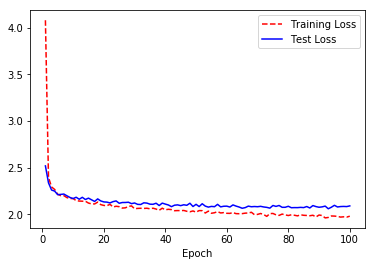

In [132]:
# get loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoch_count = range(1, len(training_loss) + 1)

# visualize loss
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")

In [133]:
model_dnn.predict(X_test)

array([[9.3565016e+00],
       [7.3621097e+00],
       [6.5030413e+00],
       [6.4302664e+00],
       [8.7014399e+00],
       [4.5564566e+00],
       [1.2402785e+00],
       [8.5584669e+00],
       [6.4910297e+00],
       [3.3077145e+00],
       [2.3040495e+00],
       [2.9384041e+00],
       [6.5304670e+00],
       [3.0903482e+00],
       [1.4353851e+00],
       [9.5603323e+00],
       [4.8983526e+00],
       [9.9060745e+00],
       [6.1955576e+00],
       [2.2522573e+00],
       [3.5906558e+00],
       [1.5703692e+00],
       [8.3733130e+00],
       [1.8462119e+00],
       [7.4172430e+00],
       [2.3284812e+00],
       [3.9189076e+00],
       [1.9098345e+00],
       [5.4251986e+00],
       [5.2870903e+00],
       [1.7482082e+00],
       [2.0545702e+00],
       [6.5389595e+00],
       [1.7415175e+00],
       [2.2270112e+00],
       [3.0955801e+00],
       [7.5107198e+00],
       [2.0431676e+00],
       [8.6511618e-01],
       [5.2146907e+00],
       [2.2016466e+00],
       [2.458830

In [134]:
MakeSubmission(model_dnn)

[[45.418102]]
[[12.590902]]
[[48.31401]]
[[44.384773]]
[[21.580414]]
[[11.862226]]
[[13.752451]]
[[45.355892]]
[[57.341965]]
[[15.108287]]
[[17.976086]]
[[11.862514]]
[[50.649902]]
[[27.766052]]
[[22.920238]]
[[36.164536]]
[[75.567795]]
[[62.487812]]
[[31.27112]]
[[33.45125]]
[[43.708614]]
[[21.933128]]
[[22.293316]]
[[34.74709]]
[[27.691067]]
[[28.497532]]
[[38.11625]]
[[15.148146]]
[[33.061687]]
[[34.364697]]
[[15.698887]]
[[23.457354]]
[[24.969034]]
[[15.275222]]
[[33.05321]]
[[31.302036]]
[[23.726028]]
[[42.91619]]
[[106.17199]]
[[60.14979]]
[[57.551292]]
[[17.880644]]
[[33.90302]]
[[19.26444]]
[[19.108732]]
[[49.935463]]
[[32.9738]]
[[12.8539]]
[[63.426964]]
[[13.70899]]
[[49.870285]]
[[48.246998]]
[[43.11887]]
[[42.537365]]
[[26.691372]]
[[30.053755]]
[[17.424757]]
[[24.703474]]
[[42.600258]]
[[53.66982]]
[[25.10117]]
[[30.923573]]
[[78.011894]]
[[39.942642]]
[[33.015224]]
[[32.581802]]
[[30.764015]]
[[28.66687]]
[[44.075394]]
[[29.001823]]
[[39.332012]]
[[37.708515]]
[[19.743229

KeyboardInterrupt: 

In [36]:
pd.read_csv("submission.csv")

,seg_id,time_to_failure
0,seg_c654e7,71.335678
1,seg_739856,22.514685
2,seg_1b08a4,76.664619
3,seg_e30e44,75.802322
4,seg_b4402d,35.940853
5,seg_284923,28.792654
6,seg_b402ac,31.002558
7,seg_655780,77.124954
8,seg_8bf229,77.095490
9,seg_2a0dc0,27.322979


### Linear Support Vector Machine

In [279]:
from sklearn.svm import LinearSVR
LinearSVR()
model_svmreg = LinearSVR(epsilon=1.5, max_iter=10000)
model_svmreg.fit(X_train, y_train.reshape(-1))

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
     random_state=None, tol=0.0001, verbose=0)

In [280]:
display_scores(model_svmreg, X_test, y_test.reshape(-1))

Scores: [-2.40050258 -2.55346107 -2.44900943 -2.60713402 -2.30821717 -2.0332136
 -1.99443742 -1.86688061 -3.02009415 -2.19788771]
Mean: -2.3430837752507223
Standard deviation: 0.3245739039308738


In [281]:
mean_absolute_error(y_test, model_svmreg.predict(X_test))

2.175581718445041

In [282]:
model_svmreg.predict(X_test)

array([ 8.40927777,  7.60328005,  7.0025426 ,  6.77734725,  9.11386149,
        4.6606734 ,  1.59523741,  8.65171838,  6.53658079,  5.22245676,
        2.63771876,  2.93320036,  7.45875419,  4.12564301,  1.09509452,
        9.92905002,  5.29620919,  9.68075314,  6.62169188,  3.5513977 ,
        3.65541234,  2.43025689,  8.97615098,  2.87608319,  7.75430818,
        3.59691045,  4.19874072,  2.36024672,  5.62382457,  5.83683642,
        2.1388318 ,  2.59790381,  6.96562787,  2.54789919,  2.24734583,
        3.69315185,  8.49215955,  2.72642808, -5.1974128 ,  5.71519098,
        2.96020654,  2.94022814,  7.98125889,  3.83984994,  7.3281676 ,
        2.96864971,  8.20597572,  2.11900181,  5.61372937,  1.8996663 ,
        7.85964593,  2.99747244,  6.2276162 ,  5.17321564,  1.42859696,
        7.82966541,  5.0426194 , -8.40340254,  4.98782111, 10.2944273 ,
        8.40051697,  3.2613196 ,  2.61474224,  3.28920299,  7.54022043,
        8.79197504,  9.20554877,  2.30534617,  1.99628965,  3.98

In [260]:
MakeSubmission(model_svmreg)